In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.utils import compute_sample_weight
from sklearn.preprocessing import OneHotEncoder


# Get data and pre-process

In [2]:
def delay_to_status(delay):
    if delay < -10:
        return "Early"
    elif -10 <= delay <= 10:
        return "On-time"
    elif 10 < delay <= 30:
        return "Late"
    else:
        return "Severely Late"

In [3]:
DESTINATION_AIRPORT = 'SYR'

# Load the historical data into a pandas dataframe
flight_data = pd.read_csv("data/flight_data.csv", parse_dates=['Date (MM/DD/YYYY)'])
destination_weather_data = pd.read_csv("data/all_destination_weather.csv", parse_dates=['destination_time'])

# Categorize delays
flight_data['Status'] = flight_data['Arrival Delay (Minutes)'].apply(delay_to_status)

# Drop unnecessary columns
flight_data.drop(columns=[
    'Flight Number',
    'Tail Number',
    'Scheduled Arrival Time',
    'Scheduled Elapsed Time (Minutes)',
    'Actual Elapsed Time (Minutes)',
    'Wheels-on Time',
    'Taxi-In time (Minutes)',
    'Delay Carrier (Minutes)',
    'Delay Weather (Minutes)',
    'Delay National Aviation System (Minutes)',
    'Delay Security (Minutes)',
    'Delay Late Aircraft Arrival (Minutes)'
], inplace=True)

# Handle missing values
flight_data.dropna(inplace=True)

# Show 10 rows of the dataframe
flight_data.head()

,Date (MM/DD/YYYY),Origin Airport,Actual Arrival Time,Arrival Delay (Minutes),Status
0,1988-01-01,ORD,19:13,-20,Early
1,1988-01-01,ORD,22:41,7,On-time
2,1989-01-01,ORD,18:27,124,Severely Late
3,1989-01-01,ORD,20:55,81,Severely Late
4,1989-01-01,ORD,9:00,-7,On-time


# Get Date Ranges for Weather Data

In [4]:
# Group flight_data by 'Origin Airport' and aggregate the min and max 'Departure Datetime' for each group
date_ranges = flight_data.groupby('Origin Airport')['Date (MM/DD/YYYY)'].agg(['min', 'max'])

# Print the 'Origin Airport' and the date range for each group
for index, row in date_ranges.iterrows():
    adjusted_min = row['min'] - pd.Timedelta(days=1)
    adjusted_max = row['max'] + pd.Timedelta(days=1)
    print(f"Origin Airport: {index}")
    print(f"Adjusted Date Range: {adjusted_min.strftime('%Y-%m-%d')} - {adjusted_max.strftime('%Y-%m-%d')}\n")

min_departure = flight_data['Date (MM/DD/YYYY)'].min() - pd.Timedelta(days=1)
max_departure = flight_data['Date (MM/DD/YYYY)'].max() + pd.Timedelta(days=1)

print(
    f"Overall Adjusted Date Range: {min_departure.strftime('%Y-%m-%d')} - {max_departure.strftime('%Y-%m-%d')}")

Origin Airport: DEN
Adjusted Date Range: 2022-02-10 - 2023-02-01

Origin Airport: EWR
Adjusted Date Range: 2019-11-29 - 2023-02-01

Origin Airport: IAD
Adjusted Date Range: 1988-06-08 - 2023-01-03

Origin Airport: ORD
Adjusted Date Range: 1987-09-30 - 2023-02-01

Overall Adjusted Date Range: 1987-09-30 - 2023-02-01


# Feature Engineering

## Add Arrival Datetime

In [5]:
# Create a boolean mask to identify rows with '24:00:00'
mask_24 = flight_data['Actual Arrival Time'] == '24:00:00'

# Replace '24:00:00' with '00:00:00'
flight_data['Actual Arrival Time'] = flight_data['Actual Arrival Time'].replace('24:00:00', '00:00:00')

# Combine date and time columns
flight_data['Arrival Datetime'] = pd.to_datetime(
    flight_data['Date (MM/DD/YYYY)'].astype(str) + ' ' + flight_data['Actual Arrival Time'])

# Add a day to the date part when the original time value was '24:00:00'
flight_data.loc[mask_24, 'Arrival Datetime'] = flight_data.loc[mask_24, 'Arrival Datetime'] + pd.Timedelta(days=1)

# Drop more unnecessary date columns
flight_data.drop(columns=[
    'Date (MM/DD/YYYY)',
    'Actual Arrival Time',
], inplace=True)

# Round to the nearest hour for the weather data
flight_data['Arrival Datetime'] = flight_data['Arrival Datetime'].dt.round("H")

# Show 10 rows of the dataframe
flight_data.head(10)

,Origin Airport,Arrival Delay (Minutes),Status,Arrival Datetime
0,ORD,-20,Early,1988-01-01 19:00:00
1,ORD,7,On-time,1988-01-01 23:00:00
2,ORD,124,Severely Late,1989-01-01 18:00:00
3,ORD,81,Severely Late,1989-01-01 21:00:00
4,ORD,-7,On-time,1989-01-01 09:00:00
5,ORD,68,Severely Late,1989-01-02 00:00:00
6,IAD,88,Severely Late,1989-01-01 15:00:00
7,IAD,66,Severely Late,1989-01-02 00:00:00
8,ORD,17,Late,1990-01-01 17:00:00
9,ORD,8,On-time,1990-01-01 23:00:00


## Time of day
Flights during certain times of the day may experience more delays, such as early morning or late evening flights.

In [6]:
def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'


flight_data['Time of Day'] = flight_data['Arrival Datetime'].dt.hour.apply(categorize_time_of_day)

# Show 10 rows of the dataframe
flight_data.head(10)

,Origin Airport,Arrival Delay (Minutes),Status,Arrival Datetime,Time of Day
0,ORD,-20,Early,1988-01-01 19:00:00,Evening
1,ORD,7,On-time,1988-01-01 23:00:00,Night
2,ORD,124,Severely Late,1989-01-01 18:00:00,Evening
3,ORD,81,Severely Late,1989-01-01 21:00:00,Night
4,ORD,-7,On-time,1989-01-01 09:00:00,Morning
5,ORD,68,Severely Late,1989-01-02 00:00:00,Night
6,IAD,88,Severely Late,1989-01-01 15:00:00,Afternoon
7,IAD,66,Severely Late,1989-01-02 00:00:00,Night
8,ORD,17,Late,1990-01-01 17:00:00,Evening
9,ORD,8,On-time,1990-01-01 23:00:00,Night


## Day of the week
Some days of the week may have more delays than others, such as weekends or Fridays, when air traffic is typically higher.

In [7]:
flight_data['Day of the Week'] = flight_data['Arrival Datetime'].dt.dayofweek
flight_data['Day of the Week'] = flight_data['Day of the Week'].astype('category')

# Show 10 rows of the dataframe
flight_data.head(10)

,Origin Airport,Arrival Delay (Minutes),Status,Arrival Datetime,Time of Day,Day of the Week
0,ORD,-20,Early,1988-01-01 19:00:00,Evening,4
1,ORD,7,On-time,1988-01-01 23:00:00,Night,4
2,ORD,124,Severely Late,1989-01-01 18:00:00,Evening,6
3,ORD,81,Severely Late,1989-01-01 21:00:00,Night,6
4,ORD,-7,On-time,1989-01-01 09:00:00,Morning,6
5,ORD,68,Severely Late,1989-01-02 00:00:00,Night,0
6,IAD,88,Severely Late,1989-01-01 15:00:00,Afternoon,6
7,IAD,66,Severely Late,1989-01-02 00:00:00,Night,0
8,ORD,17,Late,1990-01-01 17:00:00,Evening,0
9,ORD,8,On-time,1990-01-01 23:00:00,Night,0


## Month and season
Delays may be more common during certain months or seasons, such as winter months with more severe weather.

In [8]:
# Add the 'Month' feature
flight_data['Month'] = flight_data['Arrival Datetime'].dt.month
flight_data['Month'] = flight_data['Month'].astype('category')


def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'


# Add the 'Season' feature
flight_data['Season'] = flight_data['Month'].apply(month_to_season)
flight_data['Season'] = flight_data['Season'].astype('category')

# Show 10 rows of the dataframe
flight_data.head(10)

,Origin Airport,Arrival Delay (Minutes),Status,Arrival Datetime,Time of Day,Day of the Week,Month,Season
0,ORD,-20,Early,1988-01-01 19:00:00,Evening,4,1,Winter
1,ORD,7,On-time,1988-01-01 23:00:00,Night,4,1,Winter
2,ORD,124,Severely Late,1989-01-01 18:00:00,Evening,6,1,Winter
3,ORD,81,Severely Late,1989-01-01 21:00:00,Night,6,1,Winter
4,ORD,-7,On-time,1989-01-01 09:00:00,Morning,6,1,Winter
5,ORD,68,Severely Late,1989-01-02 00:00:00,Night,0,1,Winter
6,IAD,88,Severely Late,1989-01-01 15:00:00,Afternoon,6,1,Winter
7,IAD,66,Severely Late,1989-01-02 00:00:00,Night,0,1,Winter
8,ORD,17,Late,1990-01-01 17:00:00,Evening,0,1,Winter
9,ORD,8,On-time,1990-01-01 23:00:00,Night,0,1,Winter


## Flight route
Some flight routes may be more prone to delays than others due to factors such as air traffic congestion, distance, or regional weather patterns.

In [9]:
flight_data['Flight Route'] = flight_data['Origin Airport'] + '-' + DESTINATION_AIRPORT
flight_data['Flight Route'] = flight_data['Flight Route'].astype('category')

# Show 10 rows of the dataframe
flight_data.head(10)

,Origin Airport,Arrival Delay (Minutes),Status,Arrival Datetime,Time of Day,Day of the Week,Month,Season,Flight Route
0,ORD,-20,Early,1988-01-01 19:00:00,Evening,4,1,Winter,ORD-SYR
1,ORD,7,On-time,1988-01-01 23:00:00,Night,4,1,Winter,ORD-SYR
2,ORD,124,Severely Late,1989-01-01 18:00:00,Evening,6,1,Winter,ORD-SYR
3,ORD,81,Severely Late,1989-01-01 21:00:00,Night,6,1,Winter,ORD-SYR
4,ORD,-7,On-time,1989-01-01 09:00:00,Morning,6,1,Winter,ORD-SYR
5,ORD,68,Severely Late,1989-01-02 00:00:00,Night,0,1,Winter,ORD-SYR
6,IAD,88,Severely Late,1989-01-01 15:00:00,Afternoon,6,1,Winter,IAD-SYR
7,IAD,66,Severely Late,1989-01-02 00:00:00,Night,0,1,Winter,IAD-SYR
8,ORD,17,Late,1990-01-01 17:00:00,Evening,0,1,Winter,ORD-SYR
9,ORD,8,On-time,1990-01-01 23:00:00,Night,0,1,Winter,ORD-SYR


## Route Mean Delay
Calculate the mean delay for each flight route (Origin-Destination pair) in the historical data, and use this as a new feature. This can help capture the general trend of delays for a specific route.

In [10]:
# Group the flight_data by 'Flight Route' and calculate the mean 'Arrival Delay (Minutes)' for each group
mean_delay_by_route = flight_data.groupby('Flight Route')['Arrival Delay (Minutes)'].mean().reset_index()

# Rename the columns of the mean_delay_by_route DataFrame for clarity
mean_delay_by_route.columns = ['Flight Route', 'Route Mean Delay']

# Merge the mean_delay_by_route DataFrame with the original flight_data DataFrame
# This adds the 'Route Mean Delay' column to the flight_data DataFrame, with the appropriate values for each flight
flight_data = flight_data.merge(mean_delay_by_route, on='Flight Route', how='left')

# Display the first 10 rows of the updated flight_data DataFrame
flight_data.head(10)

,Origin Airport,Arrival Delay (Minutes),Status,Arrival Datetime,Time of Day,Day of the Week,Month,Season,Flight Route,Route Mean Delay
0,ORD,-20,Early,1988-01-01 19:00:00,Evening,4,1,Winter,ORD-SYR,8.238029
1,ORD,7,On-time,1988-01-01 23:00:00,Night,4,1,Winter,ORD-SYR,8.238029
2,ORD,124,Severely Late,1989-01-01 18:00:00,Evening,6,1,Winter,ORD-SYR,8.238029
3,ORD,81,Severely Late,1989-01-01 21:00:00,Night,6,1,Winter,ORD-SYR,8.238029
4,ORD,-7,On-time,1989-01-01 09:00:00,Morning,6,1,Winter,ORD-SYR,8.238029
5,ORD,68,Severely Late,1989-01-02 00:00:00,Night,0,1,Winter,ORD-SYR,8.238029
6,IAD,88,Severely Late,1989-01-01 15:00:00,Afternoon,6,1,Winter,IAD-SYR,6.451291
7,IAD,66,Severely Late,1989-01-02 00:00:00,Night,0,1,Winter,IAD-SYR,6.451291
8,ORD,17,Late,1990-01-01 17:00:00,Evening,0,1,Winter,ORD-SYR,8.238029
9,ORD,8,On-time,1990-01-01 23:00:00,Night,0,1,Winter,ORD-SYR,8.238029


## Route Delay Frequency
Calculate the frequency of delayed flights for each route. This can help capture how often a specific route experiences delays.

In [11]:
# Define a threshold for delays (in minutes)
delay_threshold = 10

# Filter the flight_data DataFrame to include only flights with 'Arrival Delay (Minutes)' greater than the threshold
delayed_flights = flight_data[flight_data['Arrival Delay (Minutes)'] > delay_threshold]

# Group the delayed_flights by 'Flight Route' and count the number of delayed flights for each group
delay_frequency_by_route = delayed_flights.groupby('Flight Route').size().reset_index()

# Rename the columns of the delay_frequency_by_route DataFrame for clarity
delay_frequency_by_route.columns = ['Flight Route', 'Route Delay Frequency']

# Merge the delay_frequency_by_route DataFrame with the original flight_data DataFrame
# This adds the 'Route Delay Frequency' column to the flight_data DataFrame, with the appropriate values for each flight
flight_data = flight_data.merge(delay_frequency_by_route, on='Flight Route', how='left')

# Fill any missing values in the 'Route Delay Frequency' column with 0
flight_data['Route Delay Frequency'] = flight_data['Route Delay Frequency'].fillna(0)

# Display the first 10 rows of the updated flight_data DataFrame
flight_data.head(10)

,Origin Airport,Arrival Delay (Minutes),Status,Arrival Datetime,Time of Day,Day of the Week,Month,Season,Flight Route,Route Mean Delay,Route Delay Frequency
0,ORD,-20,Early,1988-01-01 19:00:00,Evening,4,1,Winter,ORD-SYR,8.238029,4783
1,ORD,7,On-time,1988-01-01 23:00:00,Night,4,1,Winter,ORD-SYR,8.238029,4783
2,ORD,124,Severely Late,1989-01-01 18:00:00,Evening,6,1,Winter,ORD-SYR,8.238029,4783
3,ORD,81,Severely Late,1989-01-01 21:00:00,Night,6,1,Winter,ORD-SYR,8.238029,4783
4,ORD,-7,On-time,1989-01-01 09:00:00,Morning,6,1,Winter,ORD-SYR,8.238029,4783
5,ORD,68,Severely Late,1989-01-02 00:00:00,Night,0,1,Winter,ORD-SYR,8.238029,4783
6,IAD,88,Severely Late,1989-01-01 15:00:00,Afternoon,6,1,Winter,IAD-SYR,6.451291,235
7,IAD,66,Severely Late,1989-01-02 00:00:00,Night,0,1,Winter,IAD-SYR,6.451291,235
8,ORD,17,Late,1990-01-01 17:00:00,Evening,0,1,Winter,ORD-SYR,8.238029,4783
9,ORD,8,On-time,1990-01-01 23:00:00,Night,0,1,Winter,ORD-SYR,8.238029,4783


## Route Delay Ratio
Calculate the ratio of delayed flights to the total number of flights for each route. This can help capture the proportion of flights that experience delays on a specific route.

In [12]:
# Group the flight_data DataFrame by 'Flight Route' and count the number of flights for each group
total_flights_by_route = flight_data.groupby('Flight Route').size().reset_index()

# Rename the columns of the total_flights_by_route DataFrame for clarity
total_flights_by_route.columns = ['Flight Route', 'Total Flights']

# Merge the total_flights_by_route DataFrame with the delay_frequency_by_route DataFrame
# This creates a new DataFrame that contains the total flights and delay frequency for each route
route_delay_ratio = total_flights_by_route.merge(delay_frequency_by_route, on='Flight Route', how='left')

# Calculate the route delay ratio by dividing the 'Route Delay Frequency' by 'Total Flights' for each route
route_delay_ratio['Route Delay Ratio'] = route_delay_ratio['Route Delay Frequency'] / route_delay_ratio['Total Flights']

# Keep only the 'Flight Route' and 'Route Delay Ratio' columns in the route_delay_ratio DataFrame
route_delay_ratio = route_delay_ratio[['Flight Route', 'Route Delay Ratio']]

# Merge the route_delay_ratio DataFrame with the original flight_data DataFrame
# This adds the 'Route Delay Ratio' column to the flight_data DataFrame, with the appropriate values for each flight
flight_data = flight_data.merge(route_delay_ratio, on='Flight Route', how='left')

# Display the first 10 rows of the updated flight_data DataFrame
flight_data.head(10)

,Origin Airport,Arrival Delay (Minutes),Status,Arrival Datetime,Time of Day,Day of the Week,Month,Season,Flight Route,Route Mean Delay,Route Delay Frequency,Route Delay Ratio
0,ORD,-20,Early,1988-01-01 19:00:00,Evening,4,1,Winter,ORD-SYR,8.238029,4783,0.255325
1,ORD,7,On-time,1988-01-01 23:00:00,Night,4,1,Winter,ORD-SYR,8.238029,4783,0.255325
2,ORD,124,Severely Late,1989-01-01 18:00:00,Evening,6,1,Winter,ORD-SYR,8.238029,4783,0.255325
3,ORD,81,Severely Late,1989-01-01 21:00:00,Night,6,1,Winter,ORD-SYR,8.238029,4783,0.255325
4,ORD,-7,On-time,1989-01-01 09:00:00,Morning,6,1,Winter,ORD-SYR,8.238029,4783,0.255325
5,ORD,68,Severely Late,1989-01-02 00:00:00,Night,0,1,Winter,ORD-SYR,8.238029,4783,0.255325
6,IAD,88,Severely Late,1989-01-01 15:00:00,Afternoon,6,1,Winter,IAD-SYR,6.451291,235,0.195670
7,IAD,66,Severely Late,1989-01-02 00:00:00,Night,0,1,Winter,IAD-SYR,6.451291,235,0.195670
8,ORD,17,Late,1990-01-01 17:00:00,Evening,0,1,Winter,ORD-SYR,8.238029,4783,0.255325
9,ORD,8,On-time,1990-01-01 23:00:00,Night,0,1,Winter,ORD-SYR,8.238029,4783,0.255325


## Distance between origin and destination airports
The distance between airports could affect the likelihood of delays due to various factors, such as air traffic or weather conditions along the route.

In [13]:
cords = {
    'IATA': ['SYR', 'EWR', 'ORD', 'IAD', 'DEN'],
    'Latitude': [43.1112, 40.6925, 41.9742, 38.9445, 39.8617],
    'Longitude': [-76.1038, -74.1687, -87.9073, -77.4558, -104.6731]
}

airport_coords = pd.DataFrame(cords)
airport_coords.set_index('IATA', inplace=True)


def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c


def get_distance(row, airport_coords):
    origin_airport = row['Origin Airport']

    origin_coords = airport_coords.loc[origin_airport]
    dest_coords = airport_coords.loc[DESTINATION_AIRPORT]

    distance = haversine(origin_coords['Latitude'], origin_coords['Longitude'],
                         dest_coords['Latitude'], dest_coords['Longitude'])
    return round(distance)


# Assuming airport_coords is a dataframe indexed by IATA code with 'Latitude' and 'Longitude' columns
flight_data['Distance (km)'] = flight_data.apply(lambda row: get_distance(row, airport_coords), axis=1)

# Show 10 rows of the dataframe
flight_data.head(10)

,Origin Airport,Arrival Delay (Minutes),Status,Arrival Datetime,Time of Day,Day of the Week,Month,Season,Flight Route,Route Mean Delay,Route Delay Frequency,Route Delay Ratio,Distance (km)
0,ORD,-20,Early,1988-01-01 19:00:00,Evening,4,1,Winter,ORD-SYR,8.238029,4783,0.255325,974
1,ORD,7,On-time,1988-01-01 23:00:00,Night,4,1,Winter,ORD-SYR,8.238029,4783,0.255325,974
2,ORD,124,Severely Late,1989-01-01 18:00:00,Evening,6,1,Winter,ORD-SYR,8.238029,4783,0.255325,974
3,ORD,81,Severely Late,1989-01-01 21:00:00,Night,6,1,Winter,ORD-SYR,8.238029,4783,0.255325,974
4,ORD,-7,On-time,1989-01-01 09:00:00,Morning,6,1,Winter,ORD-SYR,8.238029,4783,0.255325,974
5,ORD,68,Severely Late,1989-01-02 00:00:00,Night,0,1,Winter,ORD-SYR,8.238029,4783,0.255325,974
6,IAD,88,Severely Late,1989-01-01 15:00:00,Afternoon,6,1,Winter,IAD-SYR,6.451291,235,0.195670,477
7,IAD,66,Severely Late,1989-01-02 00:00:00,Night,0,1,Winter,IAD-SYR,6.451291,235,0.195670,477
8,ORD,17,Late,1990-01-01 17:00:00,Evening,0,1,Winter,ORD-SYR,8.238029,4783,0.255325,974
9,ORD,8,On-time,1990-01-01 23:00:00,Night,0,1,Winter,ORD-SYR,8.238029,4783,0.255325,974


## Destination Weather Data

In [14]:
# Merge the merged_data and destination_weather_data dataframes on 'Arrival Datetime', and 'destination_time' columns using a left join
data = pd.merge(flight_data, destination_weather_data,
                left_on='Arrival Datetime',
                right_on='destination_time',
                how='left')

# Drop more unnecessary columns
data.drop(columns=[
    'Origin Airport',
    'Arrival Datetime',
    'destination_time',
], inplace=True)

# Show 10 rows of the dataframe
data.head(10)

,Arrival Delay (Minutes),Status,Time of Day,Day of the Week,Month,Season,Flight Route,Route Mean Delay,Route Delay Frequency,Route Delay Ratio,...,destination_snowfall (cm),destination_cloudcover (%),destination_cloudcover_low (%),destination_cloudcover_mid (%),destination_cloudcover_high (%),destination_windspeed_10m (km/h),destination_winddirection_10m (°),destination_windgusts_10m (km/h),destination_et0_fao_evapotranspiration (mm),destination_vapor_pressure_deficit (kPa)
0,-20,Early,Evening,4,1,Winter,ORD-SYR,8.238029,4783,0.255325,...,0.00,77,79,9,0,15.4,254,31.7,0.02,0.16
1,7,On-time,Night,4,1,Winter,ORD-SYR,8.238029,4783,0.255325,...,0.00,90,89,16,0,17.2,259,38.9,0.02,0.16
2,124,Severely Late,Evening,6,1,Winter,ORD-SYR,8.238029,4783,0.255325,...,0.00,52,42,24,0,9.7,141,21.2,0.01,0.12
3,81,Severely Late,Night,6,1,Winter,ORD-SYR,8.238029,4783,0.255325,...,0.00,100,85,21,63,14.9,173,31.3,0.01,0.14
4,-7,On-time,Morning,6,1,Winter,ORD-SYR,8.238029,4783,0.255325,...,0.00,38,8,45,11,10.0,120,18.4,0.00,0.03
5,68,Severely Late,Night,0,1,Winter,ORD-SYR,8.238029,4783,0.255325,...,0.00,95,71,4,94,15.8,180,34.2,0.01,0.12
6,88,Severely Late,Afternoon,6,1,Winter,IAD-SYR,6.451291,235,0.195670,...,0.00,17,17,2,0,10.6,145,24.1,0.11,0.25
7,66,Severely Late,Night,0,1,Winter,IAD-SYR,6.451291,235,0.195670,...,0.00,95,71,4,94,15.8,180,34.2,0.01,0.12
8,17,Late,Evening,0,1,Winter,ORD-SYR,8.238029,4783,0.255325,...,0.07,87,83,20,0,21.6,294,51.5,0.03,0.12
9,8,On-time,Night,0,1,Winter,ORD-SYR,8.238029,4783,0.255325,...,0.07,79,88,0,0,16.3,298,37.8,0.01,0.08


# Check Data

Arrival Delay (Minutes)                           int64
Status                                           object
Time of Day                                      object
Day of the Week                                category
Month                                          category
Season                                         category
Flight Route                                   category
Route Mean Delay                                float64
Route Delay Frequency                             int64
Route Delay Ratio                               float64
Distance (km)                                     int64
destination_temperature_2m (°C)                 float64
destination_relativehumidity_2m (%)               int64
destination_dewpoint_2m (°C)                    float64
destination_apparent_temperature (°C)           float64
destination_pressure_msl (hPa)                  float64
destination_surface_pressure (hPa)              float64
destination_precipitation (mm)                  

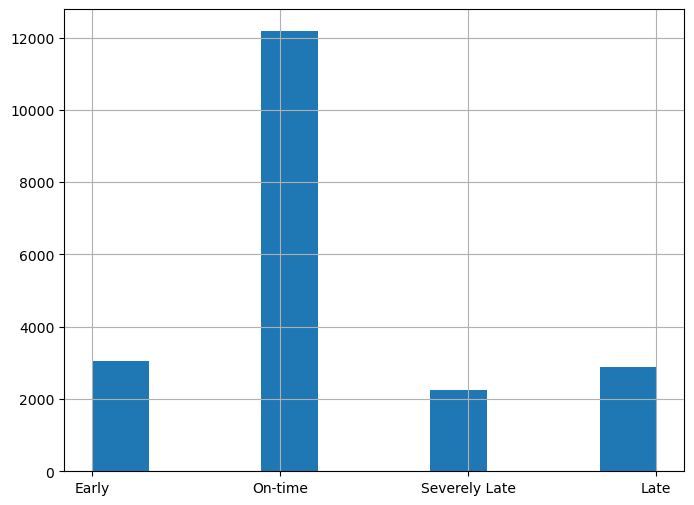

Length of flight data:  20352
Length of merged data:  20352
Total NaN values:  0


In [15]:
display(data.dtypes)

fig, ax = plt.subplots(figsize=(8, 6))
data['Status'].hist(ax=ax)
plt.show()

print("Length of flight data: ", len(flight_data))
print("Length of merged data: ", len(data))
print("Total NaN values: ", data.isna().sum().sum())

# One Hot Encoding

In [16]:
# List of columns to one-hot encode
columns_to_encode = ['Day of the Week', 'Time of Day', 'Month', 'Season', 'Flight Route']

# Create an instance of OneHotEncoder
OHE = OneHotEncoder(sparse=False)

# Fit the encoder to your data
OHE.fit(data[columns_to_encode])

# Transform your data using the encoder
encoded_data = OHE.transform(data[columns_to_encode])

# Create a new dataframe with transformed data and column names
encoded_df = pd.DataFrame(encoded_data, columns=OHE.get_feature_names_out(columns_to_encode))

# Reset index on the original dataframe
data.reset_index(drop=True, inplace=True)

# Merge the new dataframe with the original dataframe
data = pd.concat([data, encoded_df], axis=1)

# Drop the original columns
data.drop(columns=columns_to_encode, inplace=True)

# Show the modified dataframe
data.head()

,Arrival Delay (Minutes),Status,Route Mean Delay,Route Delay Frequency,Route Delay Ratio,Distance (km),destination_temperature_2m (°C),destination_relativehumidity_2m (%),destination_dewpoint_2m (°C),destination_apparent_temperature (°C),...,Month_11,Month_12,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Flight Route_DEN-SYR,Flight Route_EWR-SYR,Flight Route_IAD-SYR,Flight Route_ORD-SYR
0,-20,Early,8.238029,4783,0.255325,974,-3.2,67,-8.5,-8.6,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,7,On-time,8.238029,4783,0.255325,974,-4.5,63,-10.5,-10.3,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,124,Severely Late,8.238029,4783,0.255325,974,-0.8,80,-3.8,-4.8,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,81,Severely Late,8.238029,4783,0.255325,974,-0.6,76,-4.3,-5.5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-7,On-time,8.238029,4783,0.255325,974,-11.8,89,-13.3,-16.8,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# Split data into testing and training

In [17]:
X = data.drop(columns=['Status', 'Arrival Delay (Minutes)'])
y = data['Status']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the length of the train and test data
print("Length of train dataset: ", len(X_train))
print("Length of test dataset: ", len(X_test))

Length of train dataset:  16281
Length of test dataset:  4071


# Normalize data

In [19]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Show 10 rows of the dataframe
X_train.head(10)

,Route Mean Delay,Route Delay Frequency,Route Delay Ratio,Distance (km),destination_temperature_2m (°C),destination_relativehumidity_2m (%),destination_dewpoint_2m (°C),destination_apparent_temperature (°C),destination_pressure_msl (hPa),destination_surface_pressure (hPa),...,Month_11,Month_12,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Flight Route_DEN-SYR,Flight Route_EWR-SYR,Flight Route_IAD-SYR,Flight Route_ORD-SYR
0,0.046873,0.044538,0.000000,0.078770,0.679868,1.000000,0.827138,0.686331,0.537736,0.556802,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.188215,1.000000,0.364403,0.317483,0.768977,0.476744,0.754647,0.725180,0.599730,0.624123,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.188215,1.000000,0.364403,0.317483,0.526403,0.546512,0.527881,0.494964,0.676550,0.691445,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.188215,1.000000,0.364403,0.317483,0.567657,0.697674,0.620818,0.539568,0.467655,0.479663,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.188215,1.000000,0.364403,0.317483,0.673267,0.686047,0.730483,0.671942,0.525606,0.544180,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.188215,1.000000,0.364403,0.317483,0.445545,0.906977,0.542751,0.408633,0.672507,0.683029,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.188215,1.000000,0.364403,0.317483,0.488449,0.627907,0.513011,0.470504,0.722372,0.736325,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.188215,1.000000,0.364403,0.317483,0.386139,0.802326,0.453532,0.358273,0.598383,0.604488,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8,0.188215,1.000000,0.364403,0.317483,0.448845,0.744186,0.505576,0.410072,0.574124,0.583450,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,0.188215,1.000000,0.364403,0.317483,0.818482,0.895349,0.957249,0.869065,0.520216,0.545582,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Label Encode

In [20]:
# Instantiate the LabelEncoder
le = LabelEncoder()

# Fit and transform the target variable in the training set
y_train_encoded = le.fit_transform(y_train)

# Transform the target variable in the testing set
y_test_encoded = le.transform(y_test)

# Class Weights

In [21]:
# Calculate the sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_encoded)

# Hyperparameter tuning

In [22]:
# # Define the parameter grid for the search
# param_grid = {
#     'n_estimators': [300, 500, 700],
#     'max_depth': [7, 9, 11],
#     'learning_rate': [0.2, 0.3, 0.4],
# }
#
# # Create the XGBClassifier instance
# xgb_clf = xgb.XGBClassifier(objective='multi:softmax', seed=42)
#
# # Create the GridSearchCV instance
# grid_search = GridSearchCV(xgb_clf, param_grid, scoring='f1_weighted', cv=3, verbose=1, n_jobs=-1)
#
# # Fit the GridSearchCV to the training data
# grid_search.fit(X_train, y_train_encoded, sample_weight=sample_weights)
#
# # Retrieve the best parameters
# best_params = grid_search.best_params_
# print(f"Best parameters: {best_params}")

# Training the best model

In [23]:
# Create and train the XGBoost model
best_model = xgb.XGBClassifier(objective='multi:softmax', seed=100, n_estimators=300, max_depth=7, learning_rate=0.2)
best_model.fit(X_train, y_train_encoded, sample_weight=sample_weights)

# Make predictions
y_train_pred_encoded = best_model.predict(X_train)
y_test_pred_encoded = best_model.predict(X_test)

# Decode

In [24]:
# Inverse transform the predictions back to the original labels
y_train_pred = le.inverse_transform(y_train_pred_encoded)
y_test_pred = le.inverse_transform(y_test_pred_encoded)

# Evaluate the model

In [25]:
print('Training Classification report:')
print(classification_report(y_train, y_train_pred))

print('\nTesting Classification report:')
print(classification_report(y_test, y_test_pred))

Training Classification report:
               precision    recall  f1-score   support

        Early       1.00      0.98      0.99      9740
         Late       1.00      0.98      0.99      9740
      On-time       0.97      1.00      0.98      9740
Severely Late       1.00      0.99      0.99      9740

     accuracy                           0.99     38960
    macro avg       0.99      0.99      0.99     38960
 weighted avg       0.99      0.99      0.99     38960


Testing Classification report:
               precision    recall  f1-score   support

        Early       0.22      0.05      0.09       610
         Late       0.30      0.09      0.14       575
      On-time       0.62      0.89      0.73      2436
Severely Late       0.30      0.15      0.20       450

     accuracy                           0.57      4071
    macro avg       0.36      0.30      0.29      4071
 weighted avg       0.48      0.57      0.49      4071



In [26]:
test_output = pd.DataFrame({'actual': y_test, 'predicted': y_test_pred})

test_output.head(30)

,actual,predicted
13435,On-time,On-time
7552,On-time,Severely Late
6981,On-time,On-time
7257,On-time,On-time
4813,On-time,On-time
2013,On-time,On-time
14330,On-time,On-time
7137,Late,On-time
15933,On-time,Early
10742,Late,On-time


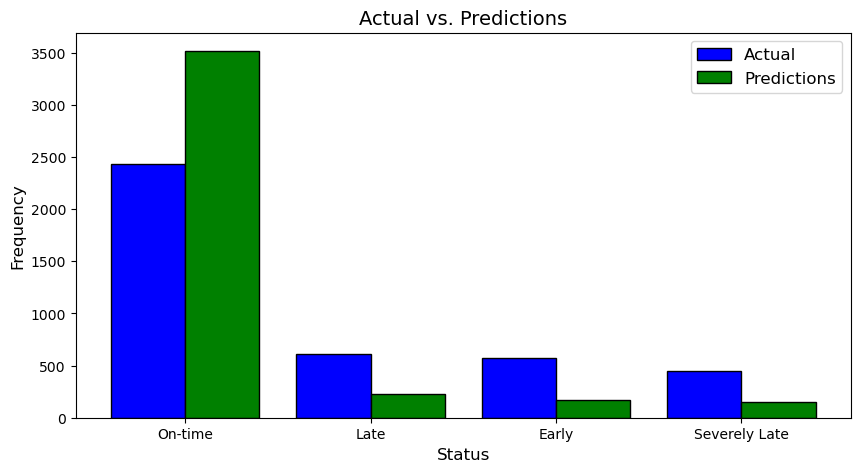

In [27]:
# Create a single figure with a specified size (width=10, height=5)
fig, ax = plt.subplots(figsize=(10, 5))

# Set the width of the bars in the histogram
bar_width = 0.4

# Create an array with the unique categories in the 'actual' and 'predicted' columns
categories = test_output.actual.unique()

# Generate the x-axis positions for each category
x_pos = np.arange(len(categories))

# Calculate the counts for each category in the 'actual' column
actual_counts = test_output.actual.value_counts()

# Calculate the counts for each category in the 'predicted' column
predicted_counts = test_output.predicted.value_counts()

# Plot the histogram of the ground truth (actual) values
ax.bar(x_pos - bar_width / 2, actual_counts, width=bar_width, color='blue', edgecolor='black', label='Actual')

# Plot the histogram of the predicted values
ax.bar(x_pos + bar_width / 2, predicted_counts, width=bar_width, color='green', edgecolor='black', label='Predictions')

# Set the x-axis ticks and labels
ax.set_xticks(x_pos)
ax.set_xticklabels(categories)

# Set the title and axis labels for the figure
ax.set_title('Actual vs. Predictions', fontsize=14)
ax.set_xlabel('Status', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Add a legend to distinguish between the two sets of data
ax.legend(fontsize=12)

# Display the figure
plt.show()

# Predict on real data

In [28]:
# Load the historical data into a pandas dataframe
real_data = pd.read_csv("data/april-12-15.csv", parse_dates=['Date'])

# Drop unnecessary columns
real_data.drop(columns=[
    'Day',
    'Flight Number',
    'Status (Early, On-time, Late, Severly Late)',
], inplace=True)

real_data.head(20)

,Date,Origin Airport,Arrival Time
0,2023-04-12,ORD,10:00 AM
1,2023-04-12,ORD,4:52 PM
2,2023-04-12,ORD,9:34 PM
3,2023-04-13,ORD,10:00 AM
4,2023-04-13,ORD,4:50 PM
5,2023-04-13,ORD,9:34 PM
6,2023-04-14,ORD,10:00 AM
7,2023-04-14,ORD,4:50 PM
8,2023-04-14,ORD,9:34 PM
9,2023-04-15,ORD,10:00 AM


## Add Arrival Datetime

In [29]:
# Create a boolean mask to identify rows with '24:00:00'
mask_24 = real_data['Arrival Time'] == '24:00:00'

# Replace '24:00:00' with '00:00:00'
real_data['Arrival Time'] = real_data['Arrival Time'].replace('24:00:00', '00:00:00')

# Combine date and time columns
real_data['Arrival Datetime'] = pd.to_datetime(
    real_data['Date'].astype(str) + ' ' + real_data['Arrival Time'])

# Add a day to the date part when the original time value was '24:00:00'
real_data.loc[mask_24, 'Arrival Datetime'] = real_data.loc[mask_24, 'Arrival Datetime'] + pd.Timedelta(days=1)

# Drop more unnecessary date columns
real_data.drop(columns=[
    'Date',
    'Arrival Time',
], inplace=True)

# Round to the nearest hour for the weather data
real_data['Arrival Datetime'] = real_data['Arrival Datetime'].dt.round("H")

# Show 10 rows of the dataframe
real_data.head(10)

,Origin Airport,Arrival Datetime
0,ORD,2023-04-12 10:00:00
1,ORD,2023-04-12 17:00:00
2,ORD,2023-04-12 22:00:00
3,ORD,2023-04-13 10:00:00
4,ORD,2023-04-13 17:00:00
5,ORD,2023-04-13 22:00:00
6,ORD,2023-04-14 10:00:00
7,ORD,2023-04-14 17:00:00
8,ORD,2023-04-14 22:00:00
9,ORD,2023-04-15 10:00:00


## Time of day

In [30]:
real_data['Time of Day'] = real_data['Arrival Datetime'].dt.hour.apply(categorize_time_of_day)

# Show 10 rows of the dataframe
real_data.head(10)

,Origin Airport,Arrival Datetime,Time of Day
0,ORD,2023-04-12 10:00:00,Morning
1,ORD,2023-04-12 17:00:00,Evening
2,ORD,2023-04-12 22:00:00,Night
3,ORD,2023-04-13 10:00:00,Morning
4,ORD,2023-04-13 17:00:00,Evening
5,ORD,2023-04-13 22:00:00,Night
6,ORD,2023-04-14 10:00:00,Morning
7,ORD,2023-04-14 17:00:00,Evening
8,ORD,2023-04-14 22:00:00,Night
9,ORD,2023-04-15 10:00:00,Morning


## Day of the week

In [31]:
real_data['Day of the Week'] = real_data['Arrival Datetime'].dt.dayofweek
real_data['Day of the Week'] = real_data['Day of the Week'].astype('category')

# Show 10 rows of the dataframe
real_data.head(10)

,Origin Airport,Arrival Datetime,Time of Day,Day of the Week
0,ORD,2023-04-12 10:00:00,Morning,2
1,ORD,2023-04-12 17:00:00,Evening,2
2,ORD,2023-04-12 22:00:00,Night,2
3,ORD,2023-04-13 10:00:00,Morning,3
4,ORD,2023-04-13 17:00:00,Evening,3
5,ORD,2023-04-13 22:00:00,Night,3
6,ORD,2023-04-14 10:00:00,Morning,4
7,ORD,2023-04-14 17:00:00,Evening,4
8,ORD,2023-04-14 22:00:00,Night,4
9,ORD,2023-04-15 10:00:00,Morning,5


## Month and Season

In [32]:
# Add the 'Month' feature
real_data['Month'] = real_data['Arrival Datetime'].dt.month
real_data['Month'] = real_data['Month'].astype('category')
# Add the 'Season' feature
real_data['Season'] = real_data['Month'].apply(month_to_season)
real_data['Season'] = real_data['Season'].astype('category')

# Show 10 rows of the dataframe
real_data.head(10)

,Origin Airport,Arrival Datetime,Time of Day,Day of the Week,Month,Season
0,ORD,2023-04-12 10:00:00,Morning,2,4,Spring
1,ORD,2023-04-12 17:00:00,Evening,2,4,Spring
2,ORD,2023-04-12 22:00:00,Night,2,4,Spring
3,ORD,2023-04-13 10:00:00,Morning,3,4,Spring
4,ORD,2023-04-13 17:00:00,Evening,3,4,Spring
5,ORD,2023-04-13 22:00:00,Night,3,4,Spring
6,ORD,2023-04-14 10:00:00,Morning,4,4,Spring
7,ORD,2023-04-14 17:00:00,Evening,4,4,Spring
8,ORD,2023-04-14 22:00:00,Night,4,4,Spring
9,ORD,2023-04-15 10:00:00,Morning,5,4,Spring


## Flight Route

In [33]:
real_data['Flight Route'] = real_data['Origin Airport'] + '-' + DESTINATION_AIRPORT
real_data['Flight Route'] = real_data['Flight Route'].astype('category')

# Show 10 rows of the dataframe
real_data.head(10)

,Origin Airport,Arrival Datetime,Time of Day,Day of the Week,Month,Season,Flight Route
0,ORD,2023-04-12 10:00:00,Morning,2,4,Spring,ORD-SYR
1,ORD,2023-04-12 17:00:00,Evening,2,4,Spring,ORD-SYR
2,ORD,2023-04-12 22:00:00,Night,2,4,Spring,ORD-SYR
3,ORD,2023-04-13 10:00:00,Morning,3,4,Spring,ORD-SYR
4,ORD,2023-04-13 17:00:00,Evening,3,4,Spring,ORD-SYR
5,ORD,2023-04-13 22:00:00,Night,3,4,Spring,ORD-SYR
6,ORD,2023-04-14 10:00:00,Morning,4,4,Spring,ORD-SYR
7,ORD,2023-04-14 17:00:00,Evening,4,4,Spring,ORD-SYR
8,ORD,2023-04-14 22:00:00,Night,4,4,Spring,ORD-SYR
9,ORD,2023-04-15 10:00:00,Morning,5,4,Spring,ORD-SYR


## Route Mean Delay

In [34]:
# Merge the mean_delay_by_route DataFrame with the original flight_data DataFrame
# This adds the 'Route Mean Delay' column to the real_data DataFrame, with the appropriate values for each flight
real_data = real_data.merge(mean_delay_by_route, on='Flight Route', how='left')

# Display the first 10 rows of the updated real_data DataFrame
real_data.head(10)

,Origin Airport,Arrival Datetime,Time of Day,Day of the Week,Month,Season,Flight Route,Route Mean Delay
0,ORD,2023-04-12 10:00:00,Morning,2,4,Spring,ORD-SYR,8.238029
1,ORD,2023-04-12 17:00:00,Evening,2,4,Spring,ORD-SYR,8.238029
2,ORD,2023-04-12 22:00:00,Night,2,4,Spring,ORD-SYR,8.238029
3,ORD,2023-04-13 10:00:00,Morning,3,4,Spring,ORD-SYR,8.238029
4,ORD,2023-04-13 17:00:00,Evening,3,4,Spring,ORD-SYR,8.238029
5,ORD,2023-04-13 22:00:00,Night,3,4,Spring,ORD-SYR,8.238029
6,ORD,2023-04-14 10:00:00,Morning,4,4,Spring,ORD-SYR,8.238029
7,ORD,2023-04-14 17:00:00,Evening,4,4,Spring,ORD-SYR,8.238029
8,ORD,2023-04-14 22:00:00,Night,4,4,Spring,ORD-SYR,8.238029
9,ORD,2023-04-15 10:00:00,Morning,5,4,Spring,ORD-SYR,8.238029


## Route Delay Frequency

In [35]:
# Merge the delay_frequency_by_route DataFrame with the original flight_data DataFrame
# This adds the 'Route Delay Frequency' column to the real_data DataFrame, with the appropriate values for each flight
real_data = real_data.merge(delay_frequency_by_route, on='Flight Route', how='left')

# Fill any missing values in the 'Route Delay Frequency' column with 0
real_data['Route Delay Frequency'] = real_data['Route Delay Frequency'].fillna(0)

# Display the first 10 rows of the updated real_data DataFrame
real_data.head(10)

,Origin Airport,Arrival Datetime,Time of Day,Day of the Week,Month,Season,Flight Route,Route Mean Delay,Route Delay Frequency
0,ORD,2023-04-12 10:00:00,Morning,2,4,Spring,ORD-SYR,8.238029,4783
1,ORD,2023-04-12 17:00:00,Evening,2,4,Spring,ORD-SYR,8.238029,4783
2,ORD,2023-04-12 22:00:00,Night,2,4,Spring,ORD-SYR,8.238029,4783
3,ORD,2023-04-13 10:00:00,Morning,3,4,Spring,ORD-SYR,8.238029,4783
4,ORD,2023-04-13 17:00:00,Evening,3,4,Spring,ORD-SYR,8.238029,4783
5,ORD,2023-04-13 22:00:00,Night,3,4,Spring,ORD-SYR,8.238029,4783
6,ORD,2023-04-14 10:00:00,Morning,4,4,Spring,ORD-SYR,8.238029,4783
7,ORD,2023-04-14 17:00:00,Evening,4,4,Spring,ORD-SYR,8.238029,4783
8,ORD,2023-04-14 22:00:00,Night,4,4,Spring,ORD-SYR,8.238029,4783
9,ORD,2023-04-15 10:00:00,Morning,5,4,Spring,ORD-SYR,8.238029,4783


## Route Delay Ratio

In [36]:
# Merge the route_delay_ratio DataFrame with the original real_data DataFrame
# This adds the 'Route Delay Ratio' column to the real_data DataFrame, with the appropriate values for each flight
real_data = real_data.merge(route_delay_ratio, on='Flight Route', how='left')

# Display the first 10 rows of the updated real_data DataFrame
real_data.head(10)

,Origin Airport,Arrival Datetime,Time of Day,Day of the Week,Month,Season,Flight Route,Route Mean Delay,Route Delay Frequency,Route Delay Ratio
0,ORD,2023-04-12 10:00:00,Morning,2,4,Spring,ORD-SYR,8.238029,4783,0.255325
1,ORD,2023-04-12 17:00:00,Evening,2,4,Spring,ORD-SYR,8.238029,4783,0.255325
2,ORD,2023-04-12 22:00:00,Night,2,4,Spring,ORD-SYR,8.238029,4783,0.255325
3,ORD,2023-04-13 10:00:00,Morning,3,4,Spring,ORD-SYR,8.238029,4783,0.255325
4,ORD,2023-04-13 17:00:00,Evening,3,4,Spring,ORD-SYR,8.238029,4783,0.255325
5,ORD,2023-04-13 22:00:00,Night,3,4,Spring,ORD-SYR,8.238029,4783,0.255325
6,ORD,2023-04-14 10:00:00,Morning,4,4,Spring,ORD-SYR,8.238029,4783,0.255325
7,ORD,2023-04-14 17:00:00,Evening,4,4,Spring,ORD-SYR,8.238029,4783,0.255325
8,ORD,2023-04-14 22:00:00,Night,4,4,Spring,ORD-SYR,8.238029,4783,0.255325
9,ORD,2023-04-15 10:00:00,Morning,5,4,Spring,ORD-SYR,8.238029,4783,0.255325


## Distance

In [37]:
# Assuming airport_coords is a dataframe indexed by IATA code with 'Latitude' and 'Longitude' columns
real_data['Distance (km)'] = real_data.apply(lambda row: get_distance(row, airport_coords), axis=1)

# Show 10 rows of the dataframe
real_data.head(10)

,Origin Airport,Arrival Datetime,Time of Day,Day of the Week,Month,Season,Flight Route,Route Mean Delay,Route Delay Frequency,Route Delay Ratio,Distance (km)
0,ORD,2023-04-12 10:00:00,Morning,2,4,Spring,ORD-SYR,8.238029,4783,0.255325,974
1,ORD,2023-04-12 17:00:00,Evening,2,4,Spring,ORD-SYR,8.238029,4783,0.255325,974
2,ORD,2023-04-12 22:00:00,Night,2,4,Spring,ORD-SYR,8.238029,4783,0.255325,974
3,ORD,2023-04-13 10:00:00,Morning,3,4,Spring,ORD-SYR,8.238029,4783,0.255325,974
4,ORD,2023-04-13 17:00:00,Evening,3,4,Spring,ORD-SYR,8.238029,4783,0.255325,974
5,ORD,2023-04-13 22:00:00,Night,3,4,Spring,ORD-SYR,8.238029,4783,0.255325,974
6,ORD,2023-04-14 10:00:00,Morning,4,4,Spring,ORD-SYR,8.238029,4783,0.255325,974
7,ORD,2023-04-14 17:00:00,Evening,4,4,Spring,ORD-SYR,8.238029,4783,0.255325,974
8,ORD,2023-04-14 22:00:00,Night,4,4,Spring,ORD-SYR,8.238029,4783,0.255325,974
9,ORD,2023-04-15 10:00:00,Morning,5,4,Spring,ORD-SYR,8.238029,4783,0.255325,974


## Destination Weather Data

In [38]:
# Merge the merged_data and destination_weather_data dataframes on 'Arrival Datetime', and 'destination_time' columns using a left join
real_data = pd.merge(real_data, destination_weather_data,
                     left_on='Arrival Datetime',
                     right_on='destination_time',
                     how='left')

# Drop more unnecessary columns
real_data.drop(columns=[
    'Origin Airport',
    'Arrival Datetime',
    'destination_time',
], inplace=True)

# Show 10 rows of the dataframe
real_data.head(10)

,Time of Day,Day of the Week,Month,Season,Flight Route,Route Mean Delay,Route Delay Frequency,Route Delay Ratio,Distance (km),destination_temperature_2m (°C),...,destination_snowfall (cm),destination_cloudcover (%),destination_cloudcover_low (%),destination_cloudcover_mid (%),destination_cloudcover_high (%),destination_windspeed_10m (km/h),destination_winddirection_10m (°),destination_windgusts_10m (km/h),destination_et0_fao_evapotranspiration (mm),destination_vapor_pressure_deficit (kPa)
0,Morning,2,4,Spring,ORD-SYR,8.238029,4783,0.255325,974,16.3,...,0.0,91,91,0,0,4.3,270,17.3,0.32,1.11
1,Evening,2,4,Spring,ORD-SYR,8.238029,4783,0.255325,974,25.6,...,0.0,0,0,0,0,27.2,276,41.8,0.44,2.17
2,Night,2,4,Spring,ORD-SYR,8.238029,4783,0.255325,974,20.5,...,0.0,0,0,0,0,17.9,242,30.6,0.14,1.48
3,Morning,3,4,Spring,ORD-SYR,8.238029,4783,0.255325,974,24.1,...,0.0,2,2,0,0,19.3,249,37.1,0.44,1.99
4,Evening,3,4,Spring,ORD-SYR,8.238029,4783,0.255325,974,30.3,...,0.0,0,0,0,0,20.7,262,31.3,0.50,3.24
5,Night,3,4,Spring,ORD-SYR,8.238029,4783,0.255325,974,20.6,...,0.0,13,0,0,13,9.2,239,22.7,0.08,1.58
6,Morning,4,4,Spring,ORD-SYR,8.238029,4783,0.255325,974,21.7,...,0.0,51,0,0,51,1.8,233,9.4,0.36,1.56
7,Evening,4,4,Spring,ORD-SYR,8.238029,4783,0.255325,974,29.9,...,0.0,2,0,0,2,6.1,357,8.6,0.37,3.29
8,Night,4,4,Spring,ORD-SYR,8.238029,4783,0.255325,974,18.9,...,0.0,19,0,0,19,5.0,69,8.3,0.04,1.31
9,Morning,5,4,Spring,ORD-SYR,8.238029,4783,0.255325,974,23.3,...,0.0,22,22,0,0,5.7,108,16.2,0.38,1.54


## Check data

In [39]:
print("Length of data: ", len(real_data))
print("Total NaN values: ", real_data.isna().sum().sum())

Length of data:  32
Total NaN values:  0


## One Hot Encoding

In [40]:
# Transform your test data using the same encoder instance
real_data_encoded = OHE.transform(real_data[columns_to_encode])

# Create a new dataframe with transformed data and column names
encoded_test_df = pd.DataFrame(real_data_encoded, columns=OHE.get_feature_names_out(columns_to_encode))

# Reset index on the original test dataframe
real_data.reset_index(drop=True, inplace=True)

# Merge the new dataframe with the original test dataframe
real_data = pd.concat([real_data, encoded_test_df], axis=1)

# Drop the original columns
real_data.drop(columns=columns_to_encode, inplace=True)

# Show the modified test dataframe
real_data.head(30)

,Route Mean Delay,Route Delay Frequency,Route Delay Ratio,Distance (km),destination_temperature_2m (°C),destination_relativehumidity_2m (%),destination_dewpoint_2m (°C),destination_apparent_temperature (°C),destination_pressure_msl (hPa),destination_surface_pressure (hPa),...,Month_11,Month_12,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Flight Route_DEN-SYR,Flight Route_EWR-SYR,Flight Route_IAD-SYR,Flight Route_ORD-SYR
0,8.238029,4783,0.255325,974,16.3,40,2.7,14.2,1013.5,998.4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,8.238029,4783,0.255325,974,25.6,34,8.6,21.2,1008.3,993.8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,8.238029,4783,0.255325,974,20.5,39,6.1,17.0,1009.9,995.1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,8.238029,4783,0.255325,974,24.1,34,7.3,20.7,1011.0,996.4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,8.238029,4783,0.255325,974,30.3,25,8.1,26.8,1007.9,993.6,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,8.238029,4783,0.255325,974,20.6,35,4.6,17.9,1010.6,995.8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,8.238029,4783,0.255325,974,21.7,40,7.5,21.2,1012.9,998.1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7,8.238029,4783,0.255325,974,29.9,22,5.9,28.0,1009.5,995.2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
8,8.238029,4783,0.255325,974,18.9,40,5.0,16.9,1010.6,995.7,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9,8.238029,4783,0.255325,974,23.3,46,11.0,23.1,1010.2,995.5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Normalize

In [41]:
real_data = pd.DataFrame(scaler.transform(real_data), columns=real_data.columns, index=real_data.index)

# Show 10 rows of the dataframe
real_data.head(10)

,Route Mean Delay,Route Delay Frequency,Route Delay Ratio,Distance (km),destination_temperature_2m (°C),destination_relativehumidity_2m (%),destination_dewpoint_2m (°C),destination_apparent_temperature (°C),destination_pressure_msl (hPa),destination_surface_pressure (hPa),...,Month_11,Month_12,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Flight Route_DEN-SYR,Flight Route_EWR-SYR,Flight Route_IAD-SYR,Flight Route_ORD-SYR
0,0.188215,1.0,0.364403,0.317483,0.683168,0.302326,0.579926,0.651799,0.545822,0.577840,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.188215,1.0,0.364403,0.317483,0.836634,0.232558,0.689591,0.752518,0.475741,0.513324,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.188215,1.0,0.364403,0.317483,0.752475,0.290698,0.643123,0.692086,0.497305,0.531557,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.188215,1.0,0.364403,0.317483,0.811881,0.232558,0.665428,0.745324,0.512129,0.549790,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.188215,1.0,0.364403,0.317483,0.914191,0.127907,0.680297,0.833094,0.470350,0.510519,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.188215,1.0,0.364403,0.317483,0.754125,0.244186,0.615242,0.705036,0.506739,0.541374,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.188215,1.0,0.364403,0.317483,0.772277,0.302326,0.669145,0.752518,0.537736,0.573633,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.188215,1.0,0.364403,0.317483,0.907591,0.093023,0.639405,0.850360,0.491914,0.532959,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0.188215,1.0,0.364403,0.317483,0.726073,0.302326,0.622677,0.690647,0.506739,0.539972,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9,0.188215,1.0,0.364403,0.317483,0.798680,0.372093,0.734201,0.779856,0.501348,0.537167,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Predict

In [42]:
y_pred_encoded = best_model.predict(real_data)

## Label Decode

In [43]:
y_pred = le.inverse_transform(y_pred_encoded)

display(y_pred)

array(['On-time', 'On-time', 'On-time', 'On-time', 'Late', 'On-time',
       'On-time', 'On-time', 'On-time', 'On-time', 'On-time', 'On-time',
       'On-time', 'On-time', 'Early', 'On-time', 'Severely Late',
       'On-time', 'On-time', 'On-time', 'On-time', 'Early', 'On-time',
       'On-time', 'On-time', 'On-time', 'On-time', 'On-time', 'On-time',
       'On-time', 'On-time', 'On-time'], dtype=object)